In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json
import os
from scipy.stats import linregress

from peaks.load_NIST import load_NIST_data
from scipy.signal import find_peaks
from plots.aniplot import load_data, load_shot
from peaks.check import multimax, compare_peaks_with_nist
from plots.plot import plot_max_spectra

In [13]:

# path_spectrometer = '/home/jessalsua/DAQ'
# path_spectrometer =  os.path.dirname(os.path.abspath(__file__))
path_spectrometer = r'C:\Users\OCEANHR_User\Spectrometer'
path_shots = os.path.join(path_spectrometer, 'Shots')
# Compare the peak wavelengths with NIST data
nist_file_path = os.path.join(path_spectrometer,'OOSpec_Control', 'peaks','ArNIST.txt')  # Adjust path as needed
He_file_path = os.path.join(path_spectrometer,'OOSpec_Control', 'peaks','HeNIST.txt')  # Adjust path as needed
ebs_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'ArEBS_Air.txt')  # Adjust path as needed
N_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'NNIST.txt')  # Adjust path as needed
O_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'ONIST.txt')  # Adjust path as needed
C_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'CNIST.txt')  # Adjust path as needed

line_files = [
    nist_file_path,
    ebs_file_path,
    N_file_path,
    O_file_path,
    C_file_path,
    He_file_path
]

colors = {
        'He I': 'blue',
        'Ar I': 'Green',
    }

shot_number = ['000160']

print(path_shots)


C:\Users\OCEANHR_User\Spectrometer\Shots


In [14]:
data_spec, max_spectra = plot_max_spectra(
    shot_number=shot_number,
    path_shots=path_shots,
    lines_files=line_files,
    spec=colors,
    ylim=[1e0, 1e5],
    min_peak=1e1,
)   

FileNotFoundError: File C:\Users\OCEANHR_User\Spectrometer\Shots\['000160'].json does not exist.

In [9]:
data_ArNIST = load_NIST_data(nist_file_path)

mask_ArNIST = np.array(data_ArNIST['Intensity']) > 100
wave_ArNIST = np.array(data_ArNIST['Wavelength'])[mask_ArNIST]

peak_index, _ = find_peaks(max_spectra['spectra'][0], height=1e3)
peak_wavelengths = max_spectra['wave'][0][peak_index]
peak_counts = max_spectra['spectra'][0][peak_index]


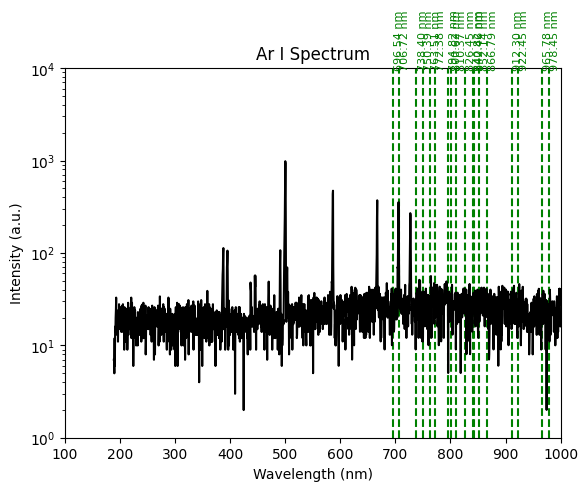

In [12]:
fig_spec, ax_spec = plt.subplots()
ax_spec.set_title('Ar I Spectrum')
ax_spec.set_xlabel('Wavelength (nm)')
ax_spec.set_ylabel('Intensity (a.u.)')
ax_spec.set_xscale('linear')
ax_spec.set_yscale('log')
ax_spec.set_xlim(100, 1000)
ax_spec.set_ylim(1e0, 1e4)
for i, wave in enumerate(wave_ArNIST):
    if wave*1e-1 < 650 or wave*1e-1 > 1000:
        continue
    if abs(wave - wave_ArNIST[i - 1]) < 15:
        continue
    ax_spec.axvline(wave*1e-1, color=colors['Ar I'], linestyle='--', label=f'Peak {i+1}: {wave:.2f} nm')
    ax_spec.text(wave*1e-1 + 2, 1e4, f'{wave*1e-1:.2f} nm', color=colors['Ar I'], fontsize=8, rotation=90)
ax_spec.plot(max_spectra['wave'][0], max_spectra['spectra'][0], label='Max Spectrum', color='black')
ax_scatter = ax_spec.scatter(peak_wavelengths, peak_counts, color='red', label='Detected Peaks')
for i, wave_peak in enumerate(peak_wavelengths):
    ax_spec.text(wave_peak + 2, peak_counts[i]  - 500, f'{wave_peak:.2f} nm', color='red', fontsize=8)
    
fig_spec.savefig(os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', f'Ar_Spectrum_{shot_number}_test.png'), dpi=300)

In [67]:

tab_energies = np.array([696.54, 706.72, 738.40, 750.39, 763.51, 772.98, 794.82, 800.62, 810.37, 826.45, 840.82, 842.46, 852.14, 912.30, 922.45, 965.78])
slope, intercept, r_value, p_value, std_err = linregress(peak_wavelengths, tab_energies)
print(f'Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}')


Slope: 1.0014041334600354, Intercept: -0.38193349510584085, R-squared: 0.9999681365308254


In [ ]:
# Save cal data in json format
cal_data = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_value**2,
    'peak_wavelengths': peak_wavelengths.tolist(),
    'tab_energies': tab_energies.tolist()
}
cal_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', f'Cal_temp.json')
with open(cal_file_path, 'w') as f:
    json.dump(cal_data, f, indent=4)
